In [1]:
import os
import sys
from collections import OrderedDict

In [2]:
sys.path.append("../")

In [3]:
import spatialpy
spatialpy.__file__

'/Users/bryanrumsey/Documents/SpatialPy/examples/../spatialpy/__init__.py'

In [4]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
class Edge1(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return abs(point[0] - MAX_X_DIM) < 0.05

In [7]:
class Edge2(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return abs(point[0] - MIN_X_DIM) < 0.05

In [8]:
class Middle(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return abs(point[0] - MIN_X_DIM) >= 0.05

In [9]:
class cylinderDemo3D(spatialpy.Model):
    MIDDLE = Middle.__name__
    EDGE1 = Edge1.__name__
    EDGE2 = Edge2.__name__
    
    def __init__(self, model_name="3D Cylinder Demo"):
        spatialpy.Model.__init__(self, model_name)

        self.timestep_size = 1
        
        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_coefficient=D_const, restrict_to=[self.MIDDLE, self.EDGE1])
        B = spatialpy.Species(name="B", diffusion_coefficient=D_const, restrict_to=[self.MIDDLE, self.EDGE2])
        self.add_species([A, B])

        # Define Domain
        domain = spatialpy.Domain.read_xml_mesh('Domain_Files/cylinder.xml')
        domain.set_properties(Middle(), self.MIDDLE)
        domain.set_properties(Edge1(), self.EDGE1)
        domain.set_properties(Edge2(), self.EDGE2)
        self.add_domain(domain)

        vol = self.domain.get_vol()
        print(f"vol {vol}")
        type_id = self.domain.type_id
        
        left = numpy.sum(vol[type_id == self.domain.get_type_def(self.EDGE1)])
        right = numpy.sum(vol[type_id == self.domain.get_type_def(self.EDGE2)])
        print(f"left {left} right {right}")
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", expression=100 / left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", expression=100 / right)
        self.add_parameter([k_react, k_creat1,k_creat2])

        # Define Reactions
        R1 = spatialpy.Reaction(reactants={}, products={A:1}, rate=k_creat1, restrict_to=self.EDGE1)
        R2 = spatialpy.Reaction(reactants={}, products={B:1}, rate=k_creat2, restrict_to=self.EDGE2)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products={}, rate=k_react)
        self.add_reaction([R1, R2, R3])
        
        # Define simulation timespan
        # timestep_size be set to much smaller than 1 for deterministic to work, increases simulation time
        self.timespan(numpy.linspace(0, 500, 501), timestep_size=1e-3)

In [10]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [11]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 7.51 ms, sys: 3.89 ms, total: 11.4 ms
Wall time: 640 ms
/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_build_5000730a


In [12]:
%time result = sol.run()
print(result.result_dir)

CPU times: user 3.25 ms, sys: 4.85 ms, total: 8.09 ms
Wall time: 4min 53s
/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_result_n20zgnmf


22998.0
22447.0
0.5092013833059308
0.505804729089437


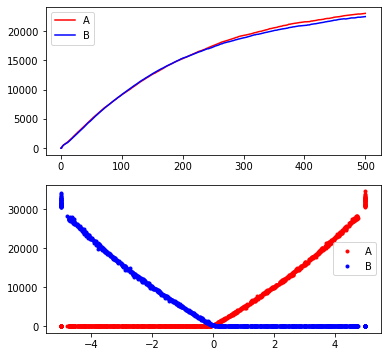

In [13]:
# Plot of the time-average spatial concentration.
x_vals = model.domain.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False, debug=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False, debug=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.domain.vol
type_id = model.domain.type_id
print(numpy.sum(vol[type_id == model.domain.get_type_def(model.EDGE1)]))
print(numpy.sum(vol[type_id == model.domain.get_type_def(model.EDGE2)]))

plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')

In [14]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

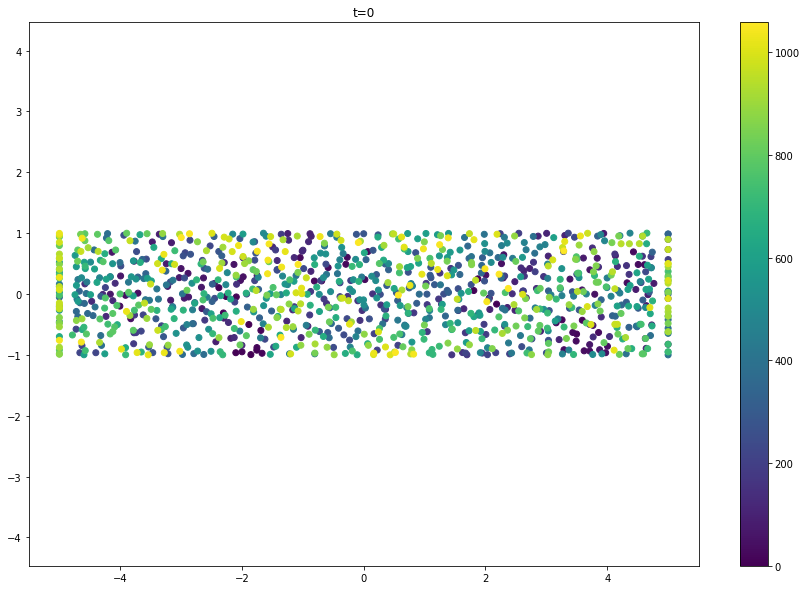

In [15]:
plot_step(0,'id')

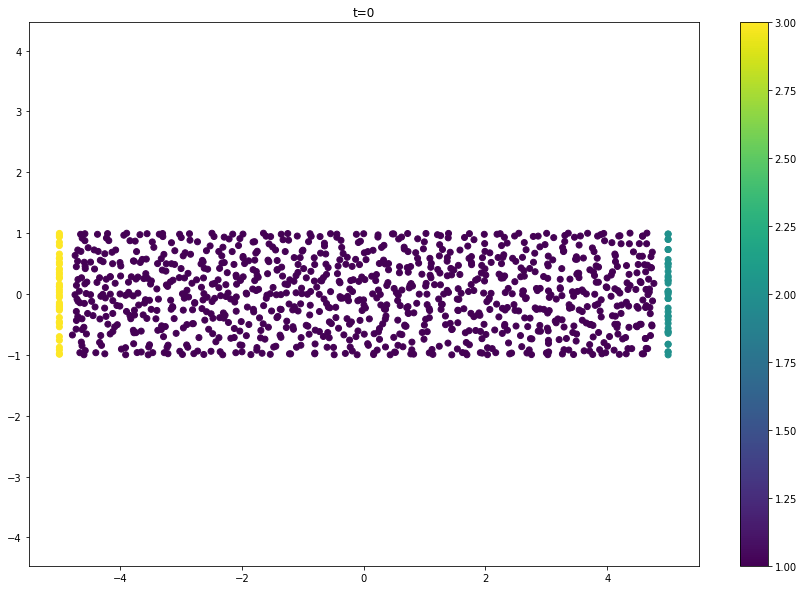

In [16]:
plot_step(0)

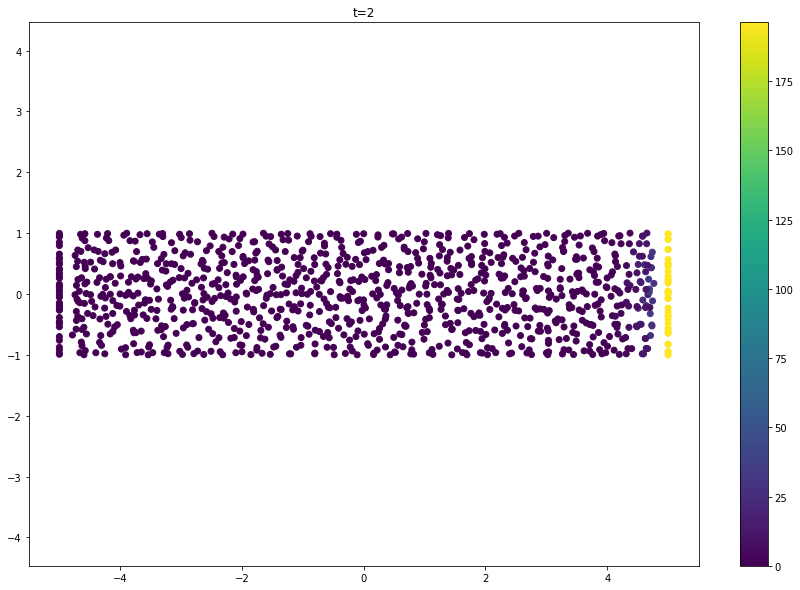

In [17]:
plot_step(2,'C[A]')

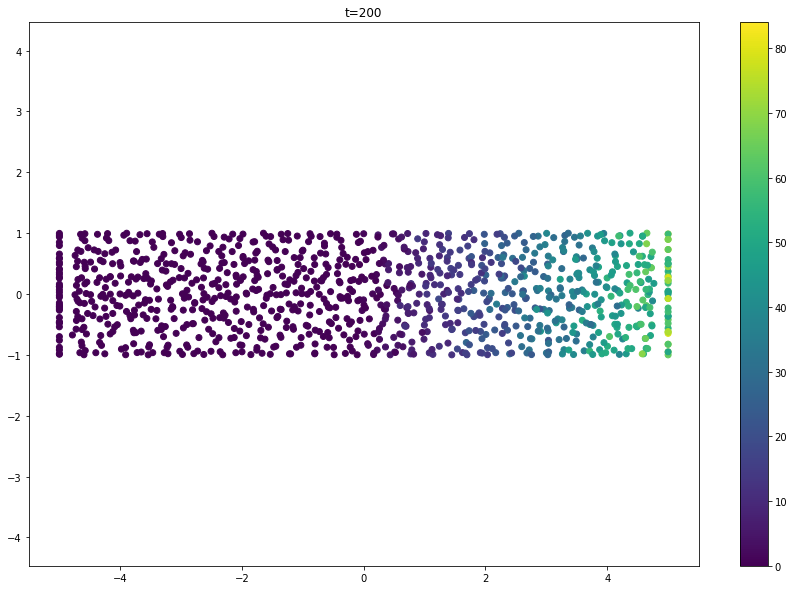

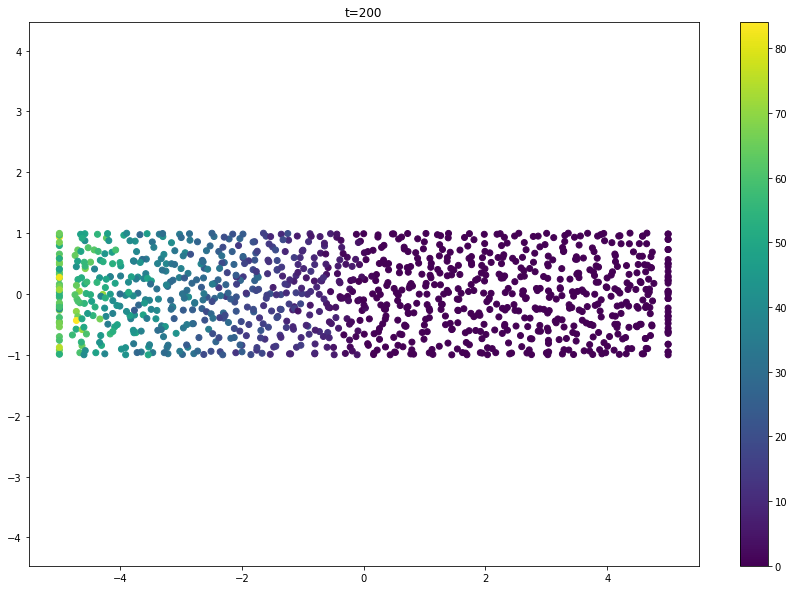

In [18]:
t=200
plot_step(t,'D[A]')
plot_step(t,'D[B]')

In [19]:
# Plot the subdomains
result.plot_property("type", 2)

In [20]:
result.plot_species("A", t_ndx=-1, deterministic=True)

In [21]:
result.plot_species("A", t_ndx=-1, size=10)

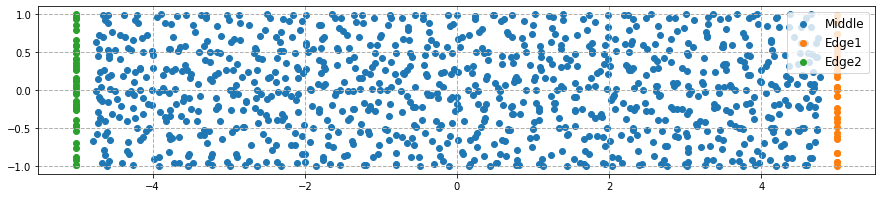

In [22]:
result.plot_property("type", use_matplotlib=True, width=15, height=10)

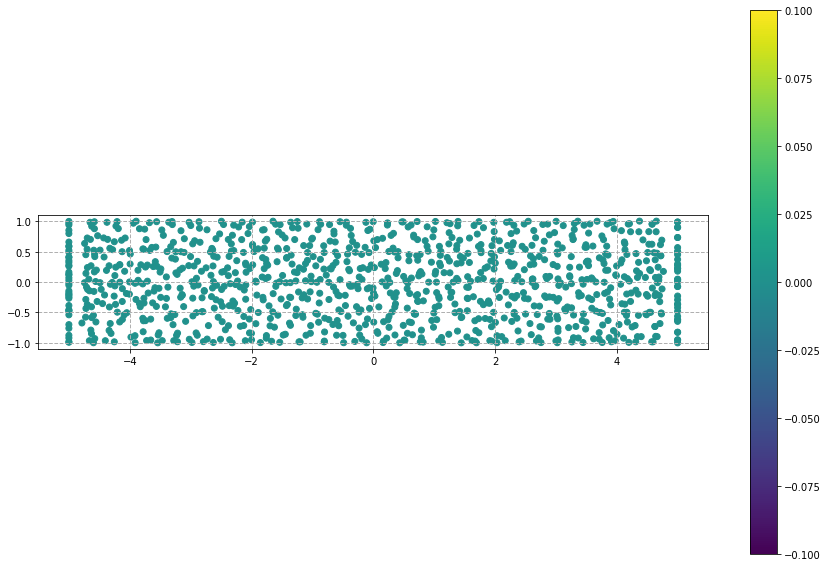

In [23]:
result.plot_species("A", deterministic=True, use_matplotlib=True, width=15, height=10)

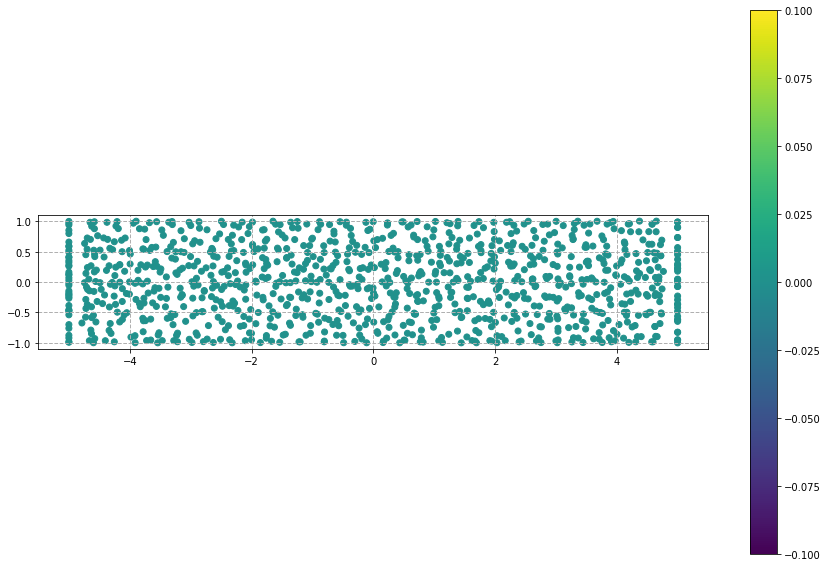

In [24]:
result.plot_species("A", use_matplotlib=True, width=15, height=10)